## Air Quality Analysis
In this section, we will perform a detailed analysis of air quality data across various major U.S. cities. Our goal is to understand trends and patterns in Air Quality Index (AQI) over time and how they correlate with urban population growth. We will utilize linear regression to explore the relationship between population and AQI, and SARIMA time series analysis to forecast future AQI and understand seasonal patterns.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# List of city names and states
cities = ['New York', 'Jacksonville', 'Dallas', 'San Antonio', 'San Diego', 'Houston', 'Phoenix', 'Philadelphia', 'Los Angeles', 'Seattle']
states = ['NY', 'FL', 'TX', 'TX', 'CA', 'TX', 'AZ', 'PA', 'CA', 'WA']

In [3]:
# Load the air quality dataset
AirQ = pd.read_csv('/Users/rileychisholm/Downloads/US_AQI_monthly.csv')

In [4]:
AirQ

City        Date         AQI                        Category  \
0      Dallas  1980-01-01   38.258065                            Good   
1      Dallas  1980-02-01   53.344828                            Good   
2      Dallas  1980-03-01   73.548387                        Moderate   
3      Dallas  1980-04-01   99.533333  Unhealthy for Sensitive Groups   
4      Dallas  1980-05-01  101.096774  Unhealthy for Sensitive Groups   
...       ...         ...         ...                             ...   
5066  Seattle  2021-10-01   43.774194                            Good   
5067  Seattle  2021-11-01   43.966667                            Good   
5068  Seattle  2021-12-01   50.096774                            Good   
5069  Seattle  2022-01-01   58.870968                        Moderate   
5070  Seattle  2022-02-01    6.000000                            Good   

     Main Pollutant state_id  density  
0               NO2       TX   1522.0  
1             Ozone       TX   1522.0  
2             Ozone       TX   1522.0  
3             Ozone       TX   1522.0  
4             Ozone       TX   1522.0  
...             ...      ...      ...  
5066          Ozone       WA   3414.0  
5067          PM2.5       WA   3414.0  
5068          PM2.5       WA   3414.0  
5069          PM2.5       WA   3414.0  
5070             CO       WA   3414.0  

[5071 rows x 7 columns]

In [5]:
# Converts DATE to datetime
AirQ['Date'] = pd.to_datetime(AirQ['Date'])

In [6]:
# Load and merge weather data with AQI data
combined_df = pd.read_csv('/Users/rileychisholm/Downloads/Combined_Weather_Data.csv')
combined_df['DATE'] = pd.to_datetime(combined_df['DATE'])

In [7]:
# Merge the dataframes on 'City' and 'Date'
merged_df = pd.merge(AirQ, combined_df[['City', 'DATE', 'Population']], left_on=['City', 'Date'], right_on=['City', 'DATE'], how='left')


In [8]:
merged_df

City       Date         AQI                        Category  \
0      Dallas 1980-01-01   38.258065                            Good   
1      Dallas 1980-02-01   53.344828                            Good   
2      Dallas 1980-03-01   73.548387                        Moderate   
3      Dallas 1980-04-01   99.533333  Unhealthy for Sensitive Groups   
4      Dallas 1980-05-01  101.096774  Unhealthy for Sensitive Groups   
...       ...        ...         ...                             ...   
5066  Seattle 2021-10-01   43.774194                            Good   
5067  Seattle 2021-11-01   43.966667                            Good   
5068  Seattle 2021-12-01   50.096774                            Good   
5069  Seattle 2022-01-01   58.870968                        Moderate   
5070  Seattle 2022-02-01    6.000000                            Good   

     Main Pollutant state_id  density       DATE  Population  
0               NO2       TX   1522.0 1980-01-01    904078.0  
1             Ozone       TX   1522.0 1980-02-01    904078.0  
2             Ozone       TX   1522.0 1980-03-01    904078.0  
3             Ozone       TX   1522.0 1980-04-01    904078.0  
4             Ozone       TX   1522.0 1980-05-01    904078.0  
...             ...      ...      ...        ...         ...  
5066          Ozone       WA   3414.0 2021-10-01    737015.0  
5067          PM2.5       WA   3414.0 2021-11-01    737015.0  
5068          PM2.5       WA   3414.0 2021-12-01    737015.0  
5069          PM2.5       WA   3414.0 2022-01-01    737015.0  
5070             CO       WA   3414.0 2022-02-01    737015.0  

[5071 rows x 9 columns]

In [9]:
# Drop rows with missing values
merged_df.dropna(inplace=True)

In [10]:
# Counts missing values per column
missing_values = merged_df.isnull().sum()
print(missing_values)

City              0
Date              0
AQI               0
Category          0
Main Pollutant    0
state_id          0
density           0
DATE              0
Population        0
dtype: int64


### Exploratory Data Analysis (EDA)
In this step, we'll perform some initial exploratory data analysis to get a sense of the trends in AQI over time. We'll also visualize the distribution of AQI by month to identify any seasonal patterns.

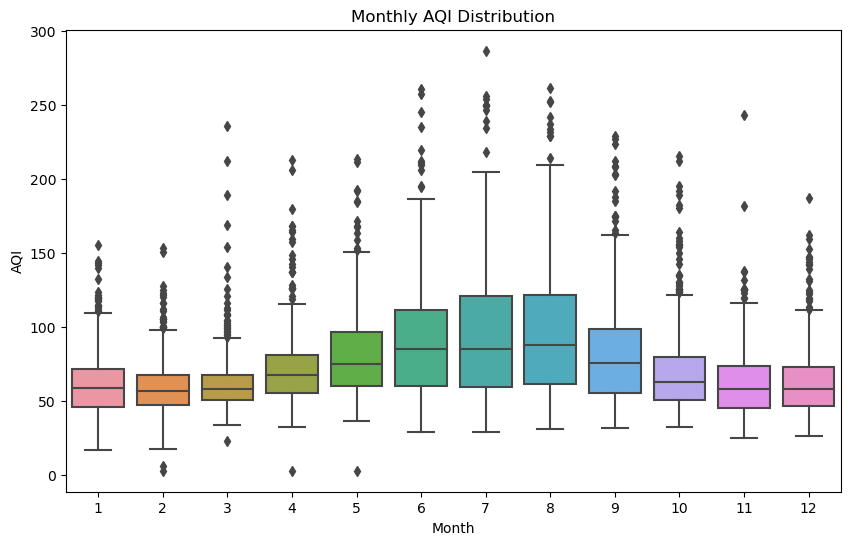

In [11]:
# Box plot for AQI by month
AirQ['month'] = AirQ['Date'].dt.month

plt.figure(figsize=(10, 6))
sns.boxplot(x='month', y='AQI', data=AirQ)
plt.xlabel('Month')
plt.ylabel('AQI')
plt.title('Monthly AQI Distribution')
plt.show()

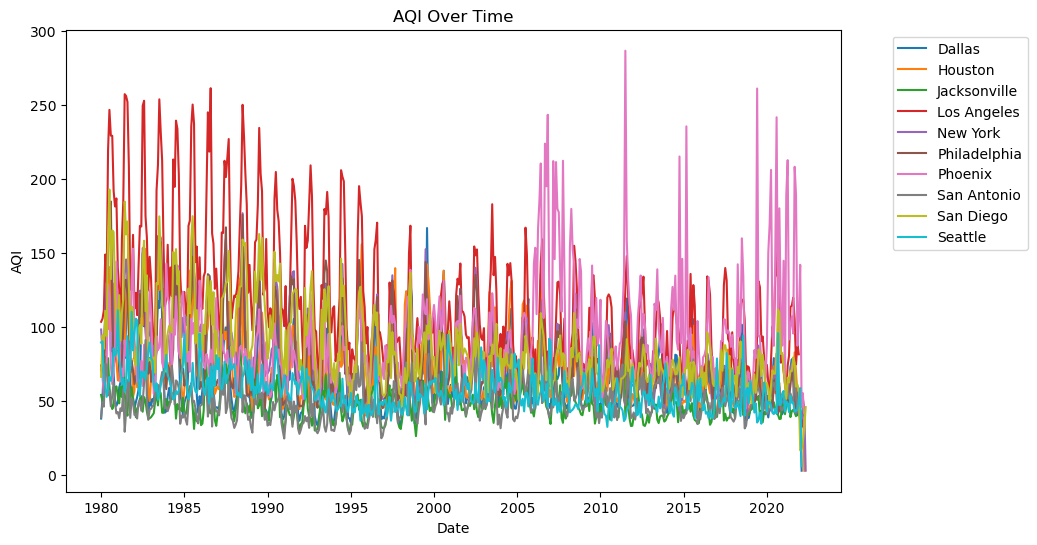

In [12]:
# Times series plot for AQI
plt.figure(figsize=(10, 6))
sns.lineplot(data=AirQ, x='Date', y='AQI', hue='City')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.title('AQI Over Time')
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
plt.show()

### Linear Regression Analysis
To understand how urban population growth impacts air quality, we perform linear regression analysis for each city. We aim to predict the AQI based on the urban population of the city.


In [13]:
# Function to perform linear regression analysis for one city
def linear_regression_city(city_name):
    # Filter for one city
    city_aqi_df = AirQ[AirQ['City'] == city_name]

    # Merge with population data
    city_pop_df = combined_df[combined_df['City'] == city_name][['Year', 'Population']].drop_duplicates()
    city_merged_df = pd.merge(city_aqi_df, city_pop_df, left_on=city_aqi_df['Date'].dt.year, right_on='Year', how='left')

    # Check for NaN values after merging and drop NaN rows if any
    city_merged_df.dropna(inplace=True)

    # Linear Regression model for AQI prediction based on urban population
    X = city_merged_df[['Population']]
    y = city_merged_df['AQI']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create and fit the model
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = lr_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'\nAnalysis for {city_name}:\n')
    print(f'Mean Squared Error: {mse}')
    print(f'R-squared: {r2}')

    # Plot predictions vs actual values
    plt.figure(figsize=(10, 6))
    plt.scatter(X_test, y_test, color='blue', label='Actual')
    plt.plot(X_test, y_pred, color='red', linewidth=2, label='Predicted')
    plt.title(f'Linear Regression: Predicted vs Actual AQI for {city_name}')
    plt.xlabel('Urban Population')
    plt.ylabel('AQI')
    plt.legend()
    plt.show()


Analysis for New York:

Mean Squared Error: 376.48541982251123
R-squared: 0.48890574144435583


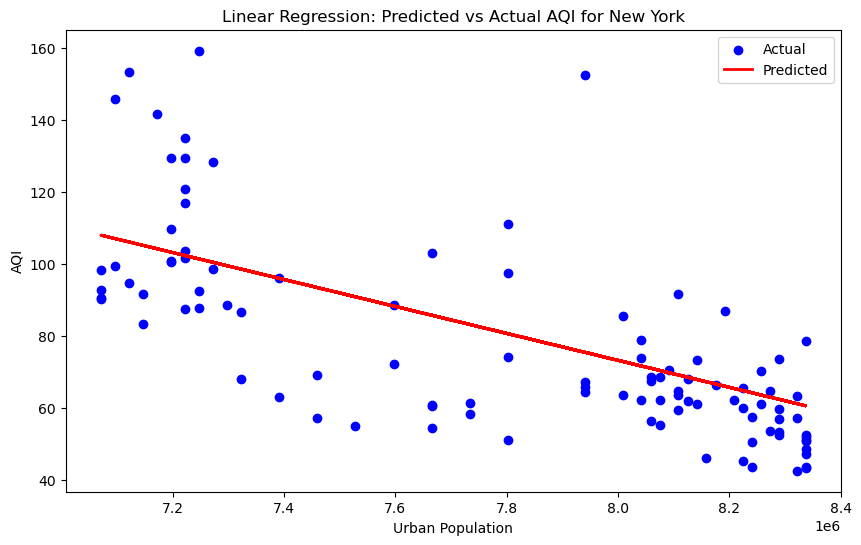


Analysis for Jacksonville:

Mean Squared Error: 90.03054320627787
R-squared: 0.03611491555990953


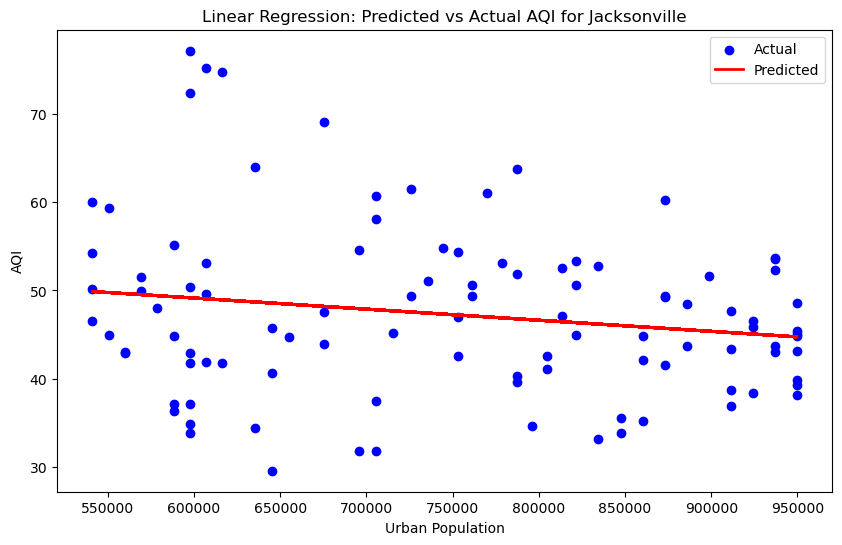


Analysis for Dallas:

Mean Squared Error: 483.8178058909507
R-squared: 0.06862875121638912


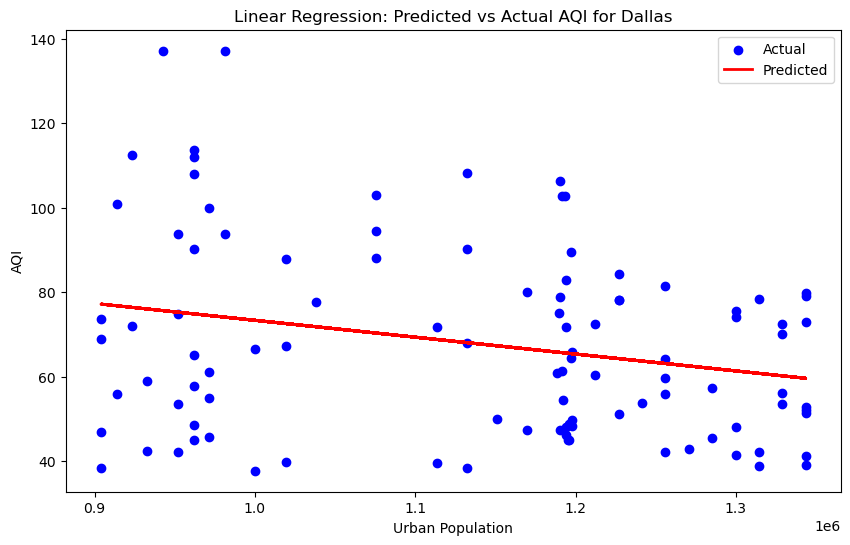


Analysis for San Antonio:

Mean Squared Error: 111.03432856504358
R-squared: 0.010877043120666174


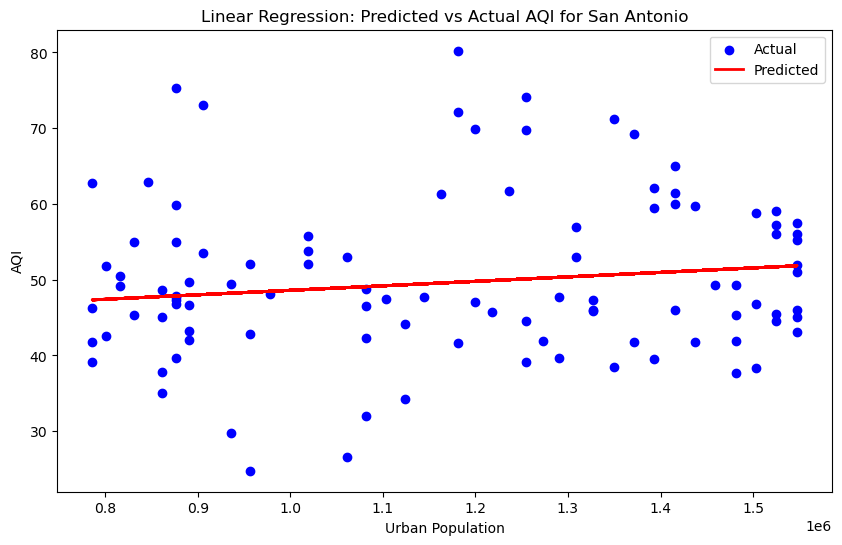


Analysis for San Diego:

Mean Squared Error: 450.907307166209
R-squared: 0.3880670293128037


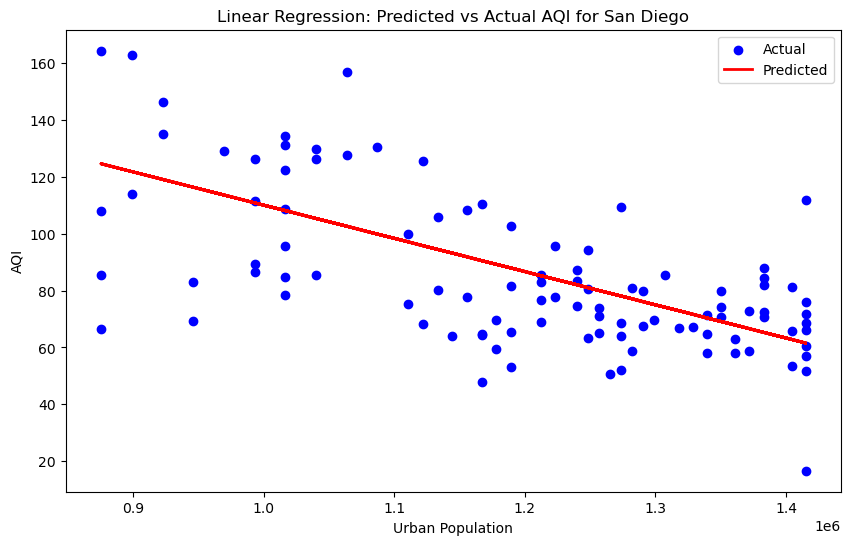


Analysis for Houston:

Mean Squared Error: 487.00937195008686
R-squared: 0.2256807592626957


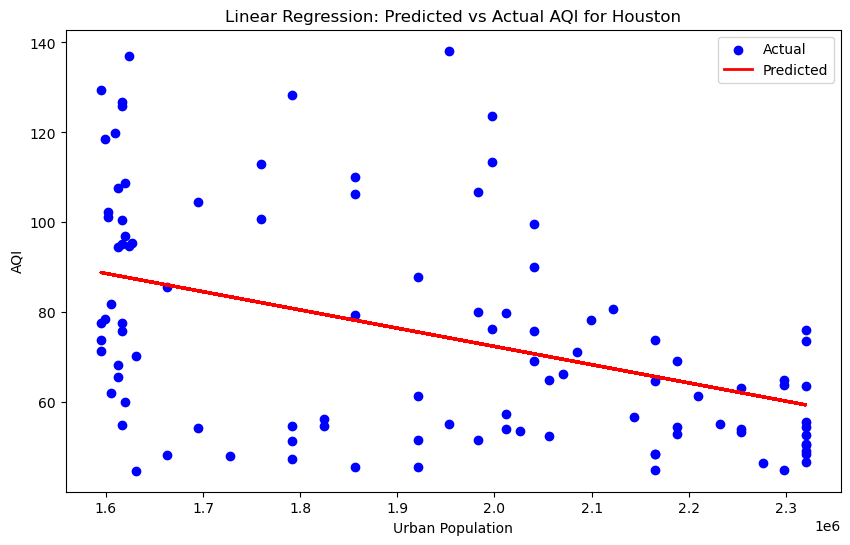


Analysis for Phoenix:

Mean Squared Error: 1133.3011656934848
R-squared: 0.04452873313304806


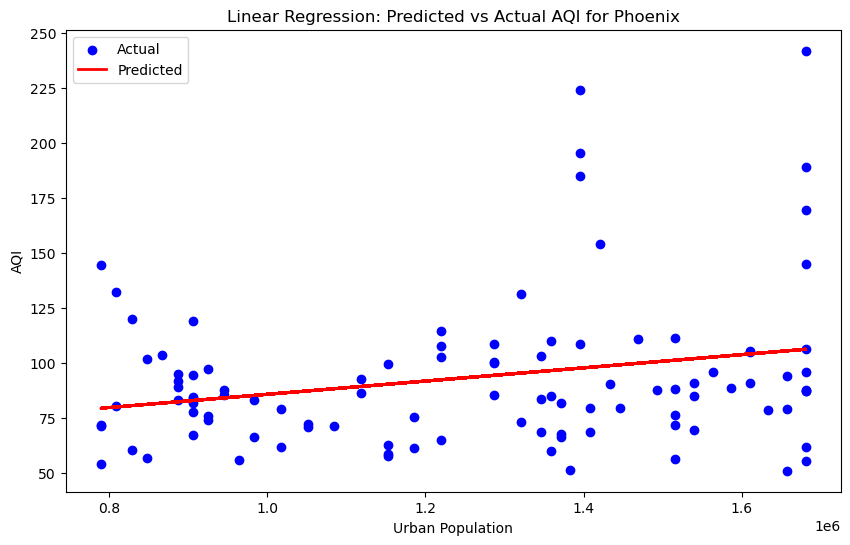


Analysis for Philadelphia:

Mean Squared Error: 689.310922711556
R-squared: 0.02491875872012861


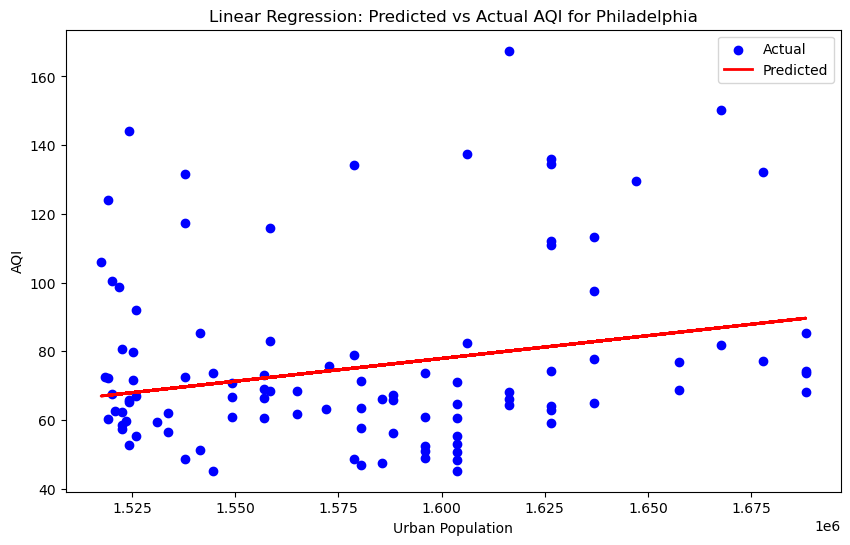


Analysis for Los Angeles:

Mean Squared Error: 1509.9884200582753
R-squared: 0.3900958194852546


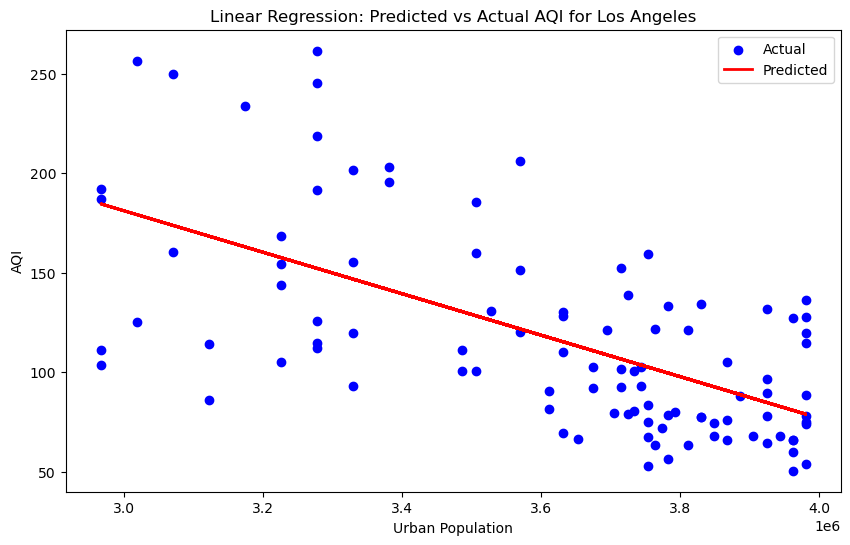


Analysis for Seattle:

Mean Squared Error: 145.26401473551454
R-squared: 0.21758624531162418


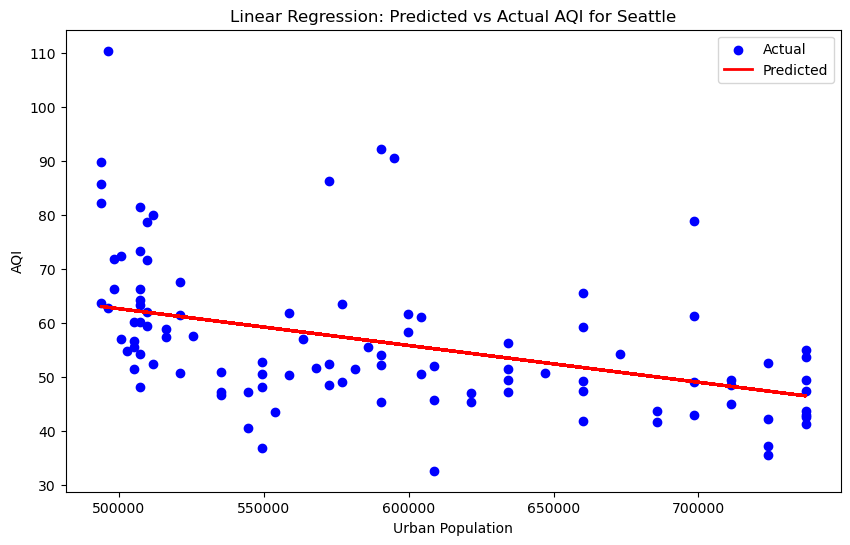

In [14]:
# Perform analysis for each city
for city in cities:
    linear_regression_city(city)

### K-means Clustering
To group cities based on their AQI and population characteristics, we apply K-means clustering. This will help identify clusters of cities that exhibit similar air quality patterns relative to their population sizes.

In [15]:
# Prepare the data for clustering
clustering_data = merged_df[['AQI', 'Population']].dropna()

In [16]:
# K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
merged_df['Cluster'] = kmeans.fit_predict(clustering_data)

/Users/rileychisholm/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


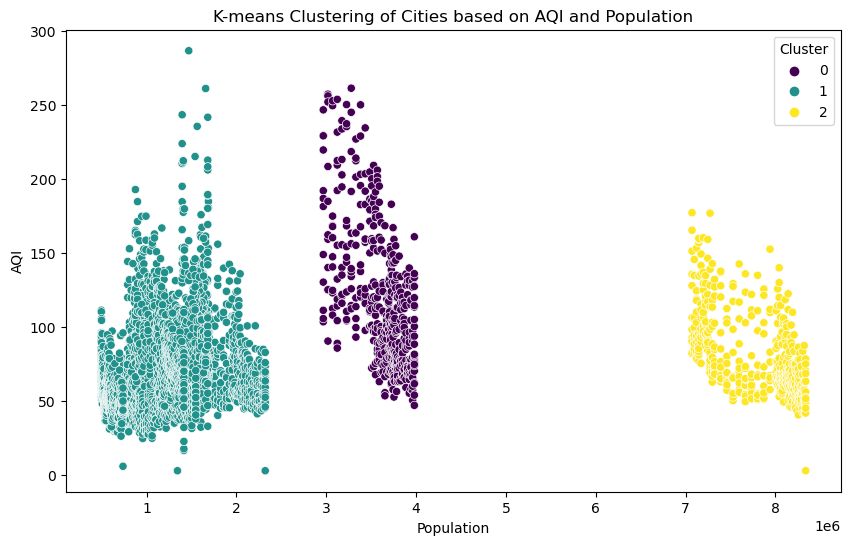

In [17]:
# Visualization of clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='Population', y='AQI', hue='Cluster', palette='viridis')
plt.xlabel('Population')
plt.ylabel('AQI')
plt.title('K-means Clustering of Cities based on AQI and Population')
plt.show()

### SARIMA Time Series Analysis
To forecast future AQI values and understand seasonal patterns, we apply SARIMA time series analysis for each city. This analysis helps in identifying the underlying trend and seasonality in the air quality data.

In [18]:
# Function to perform SARIMA time series analysis for one city
def sarima_city(city_name, train_ratio=0.8):
    # Filter for one city
    city_aqi_df = AirQ[AirQ['City'] == city_name]
    city_aqi_df.set_index('Date', inplace=True)

    # Decompose the time series to show trend and seasonality
    if len(city_aqi_df) >= 24: 
        decomposition = seasonal_decompose(city_aqi_df['AQI'], model='additive', period=12)
        
        plt.figure(figsize=(12, 8))
        plt.suptitle(f'SARIMA Decomposition for {city_name}', fontsize=16)
        plt.subplot(411)
        plt.plot(city_aqi_df['AQI'], label='Original')
        plt.legend(loc='upper left')
        plt.subplot(412)
        plt.plot(decomposition.trend, label='Trend')
        plt.legend(loc='upper left')
        plt.subplot(413)
        plt.plot(decomposition.seasonal, label='Seasonality')
        plt.legend(loc='upper left')
        plt.subplot(414)
        plt.plot(decomposition.resid, label='Residuals')
        plt.legend(loc='upper left')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
    else:
        print(f"Not enough data for seasonal decomposition for {city_name}. Required: 24, Available: {len(city_aqi_df)}")
    
    # Split the data into training and testing sets
    train_size = int(len(city_aqi_df) * train_ratio)
    train, test = city_aqi_df[:train_size], city_aqi_df[train_size:]
    
    # Fit SARIMA model on training set
    model = sm.tsa.statespace.SARIMAX(train['AQI'], 
                                      order=(5, 1, 0), 
                                      seasonal_order=(1, 1, 1, 12))
    results = model.fit()
    
    # Forecast the test set
    forecast = results.get_forecast(steps=len(test))
    forecast_values = forecast.predicted_mean
    conf_int = forecast.conf_int()

    # Plot the original, forecasted, and test values
    plt.figure(figsize=(10, 6))
    plt.plot(city_aqi_df['AQI'], label='Original')
    plt.plot(results.fittedvalues, color='red', label='Fitted')
    plt.plot(forecast_values, color='green', label='Forecast')
    plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
    plt.title(f'SARIMA Time Series Analysis for {city_name}')
    plt.xlabel('Date')
    plt.ylabel('AQI')
    plt.legend()
    plt.show()

    print(f"SARIMA Model Summary for {city_name}")


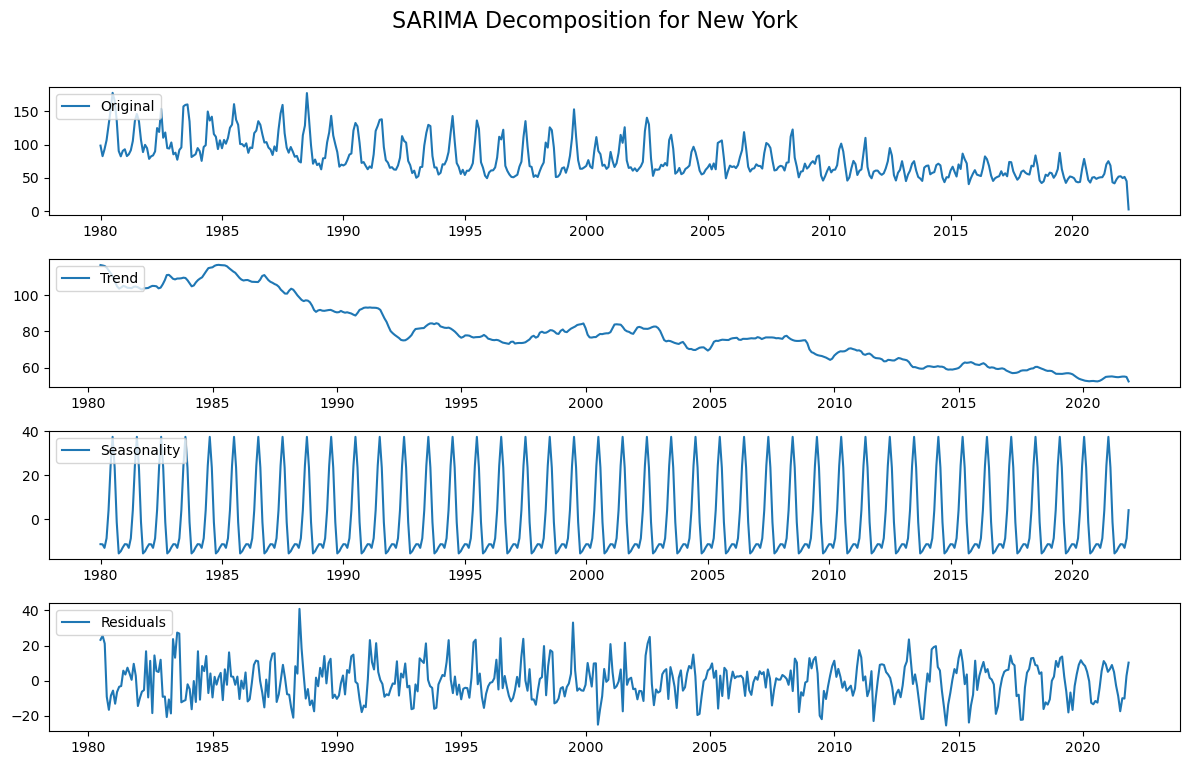

/Users/rileychisholm/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/rileychisholm/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.77636D+00    |proj g|=  7.37346D-02

At iterate    5    f=  3.73019D+00    |proj g|=  4.61079D-02

At iterate   10    f=  3.69245D+00    |proj g|=  9.43196D-02

At iterate   15    f=  3.68670D+00    |proj g|=  3.49912D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     18     23      1     0     0   3.519D-06   3.687D+00
  F =   3.6866995800837530     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


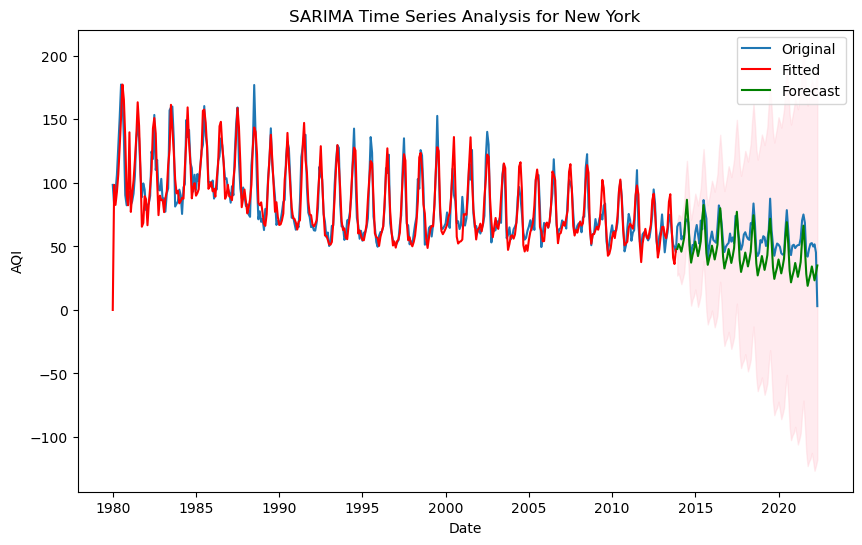

SARIMA Model Summary for New York


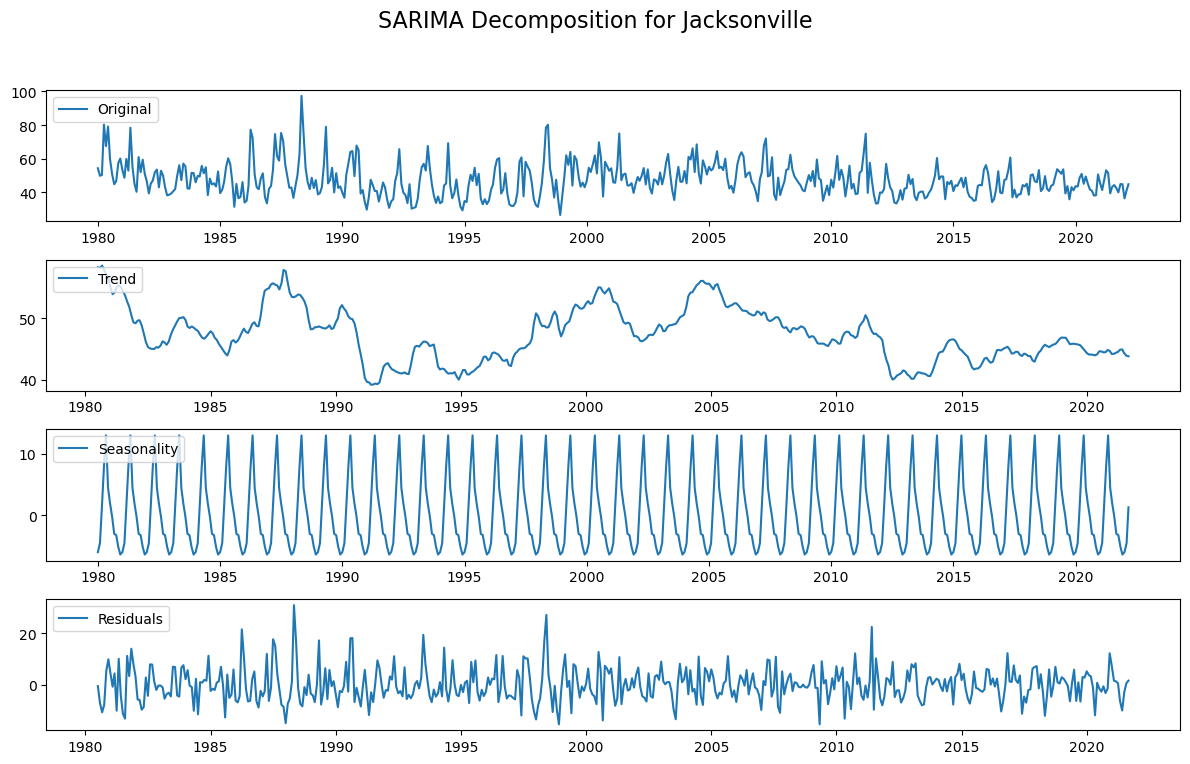

/Users/rileychisholm/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/rileychisholm/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.51660D+00    |proj g|=  8.39859D-02

At iterate    5    f=  3.43740D+00    |proj g|=  6.57281D-02

At iterate   10    f=  3.41481D+00    |proj g|=  1.75753D-03

At iterate   15    f=  3.41457D+00    |proj g|=  1.44772D-02

At iterate   20    f=  3.41404D+00    |proj g|=  1.15170D-03

At iterate   25    f=  3.41404D+00    |proj g|=  6.28924D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     25     29      1     0     0   

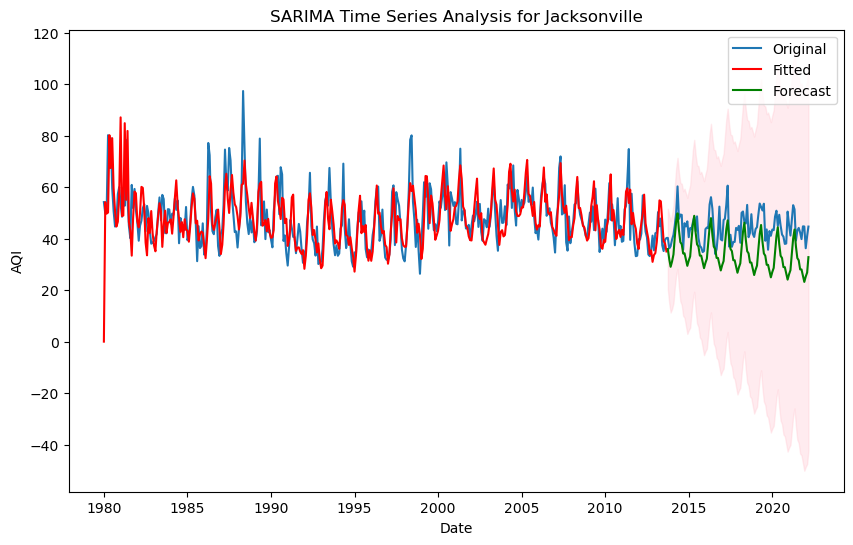

SARIMA Model Summary for Jacksonville


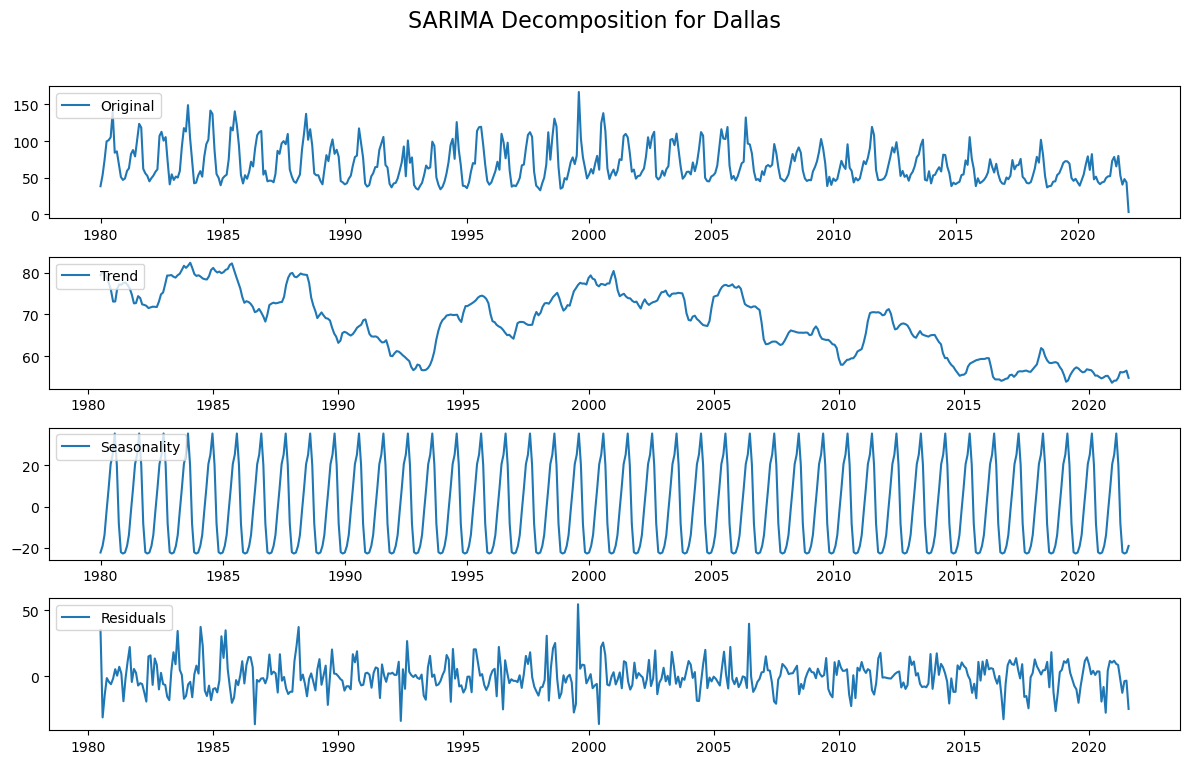

/Users/rileychisholm/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/rileychisholm/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.99209D+00    |proj g|=  6.00771D-02

At iterate    5    f=  3.94386D+00    |proj g|=  1.94269D-02

At iterate   10    f=  3.91225D+00    |proj g|=  9.18038D-03

At iterate   15    f=  3.91211D+00    |proj g|=  2.28272D-04

At iterate   20    f=  3.91058D+00    |proj g|=  4.39377D-02

At iterate   25    f=  3.90863D+00    |proj g|=  4.01110D-03

At iterate   30    f=  3.90846D+00    |proj g|=  2.89263D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

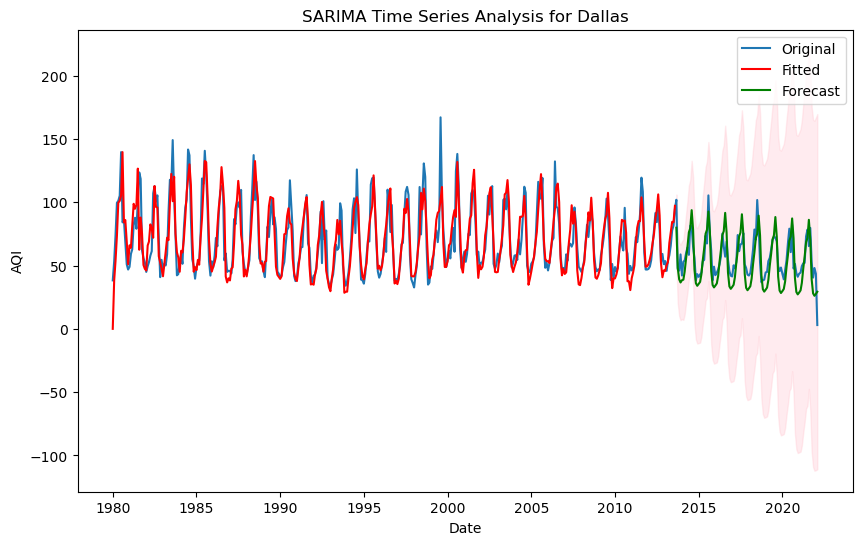

SARIMA Model Summary for Dallas


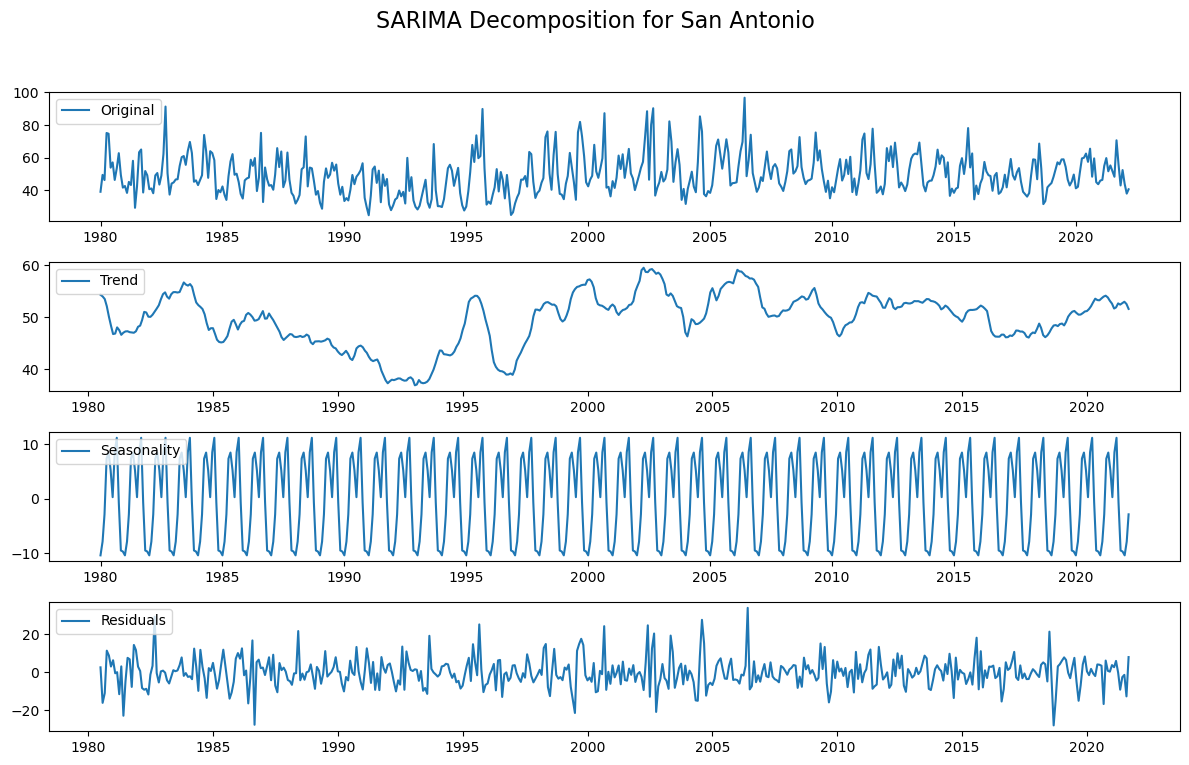

/Users/rileychisholm/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/rileychisholm/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.67317D+00    |proj g|=  7.38892D-02

At iterate    5    f=  3.59416D+00    |proj g|=  2.99773D-02

At iterate   10    f=  3.55726D+00    |proj g|=  1.58050D-03

At iterate   15    f=  3.55726D+00    |proj g|=  2.78279D-04

At iterate   20    f=  3.55724D+00    |proj g|=  2.86314D-03

At iterate   25    f=  3.55718D+00    |proj g|=  1.34576D-03

At iterate   30    f=  3.55717D+00    |proj g|=  1.84232D-04

At iterate   35    f=  3.55717D+00    |proj g|=  8.95934D-05

At iterate   40    f=  3.55717D+00    |proj g|=  5.67958D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

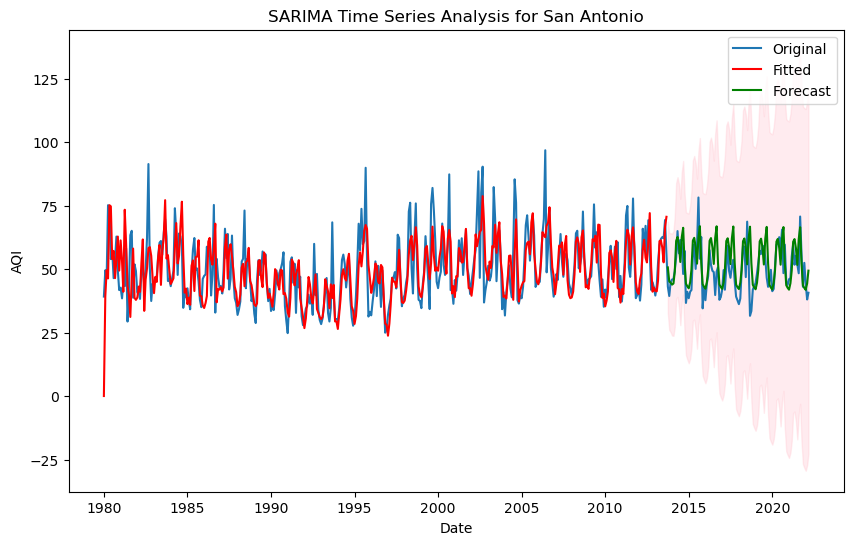

SARIMA Model Summary for San Antonio


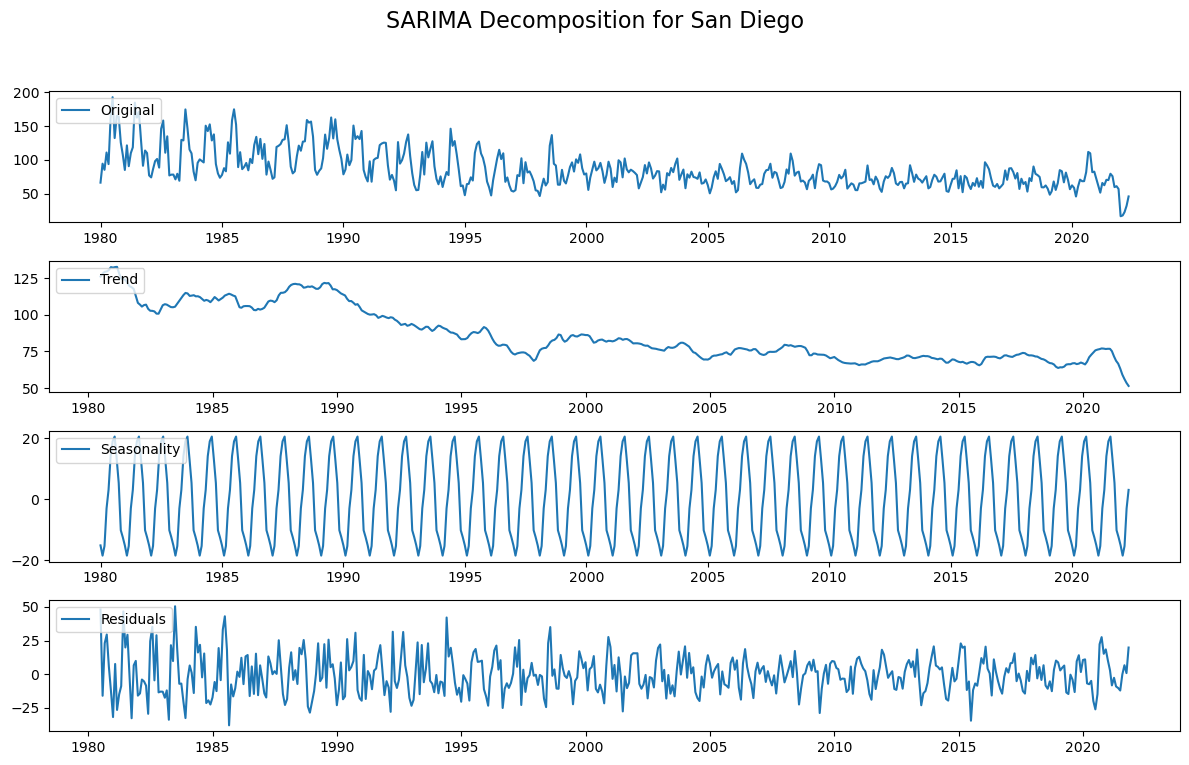

/Users/rileychisholm/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/rileychisholm/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.12149D+00    |proj g|=  4.46224D-02

At iterate    5    f=  4.09872D+00    |proj g|=  2.02688D-02

At iterate   10    f=  4.08090D+00    |proj g|=  4.20342D-02

At iterate   15    f=  4.07118D+00    |proj g|=  3.46275D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     18     23      1     0     0   3.411D-06   4.071D+00
  F =   4.0711818936681423     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


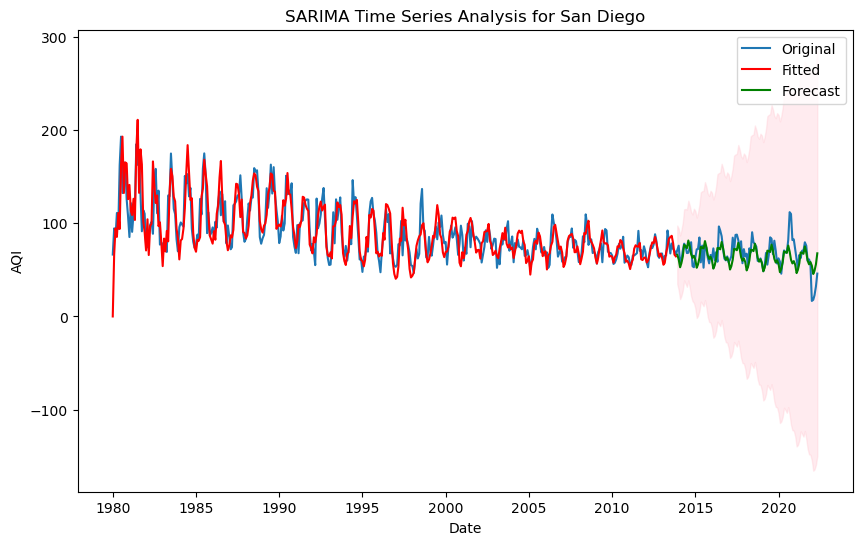

SARIMA Model Summary for San Diego


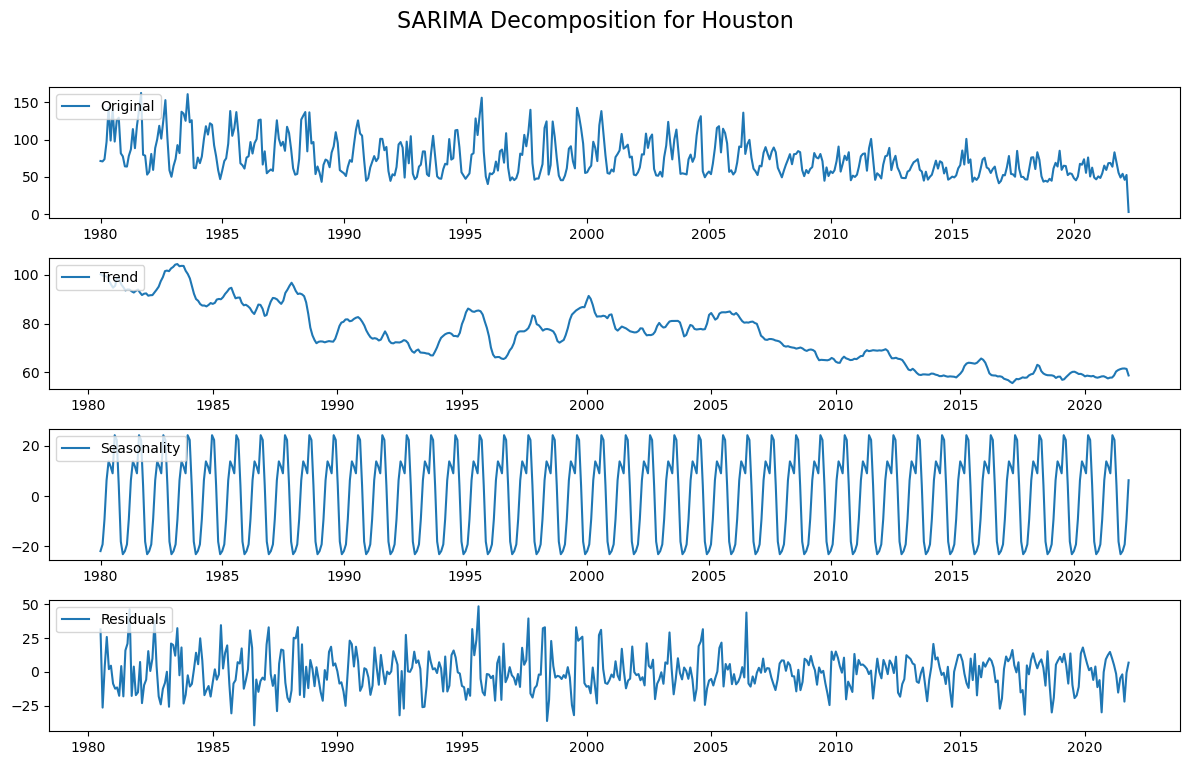

/Users/rileychisholm/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/rileychisholm/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.20259D+00    |proj g|=  6.56821D-02

At iterate    5    f=  4.14534D+00    |proj g|=  1.62608D-02

At iterate   10    f=  4.10789D+00    |proj g|=  3.89823D-02

At iterate   15    f=  4.10507D+00    |proj g|=  7.74000D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     17     19      1     0     0   3.978D-05   4.105D+00
  F =   4.1050662250044878     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


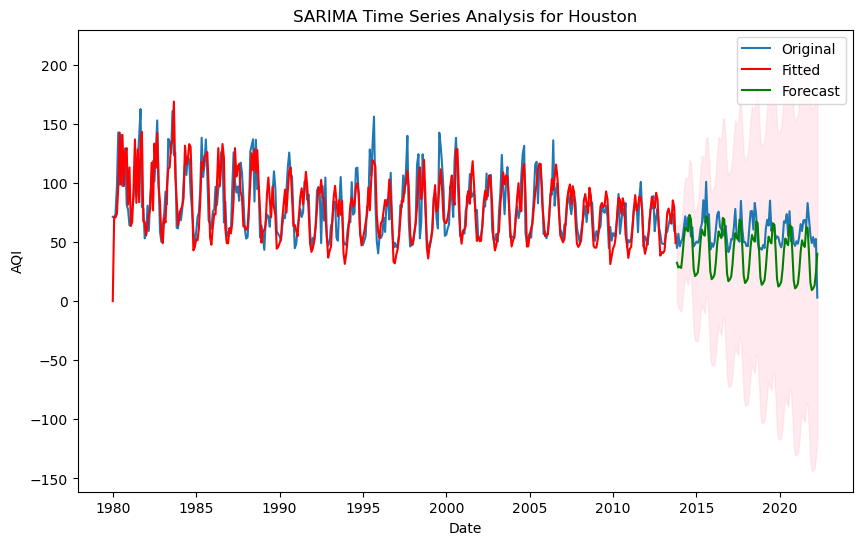

SARIMA Model Summary for Houston


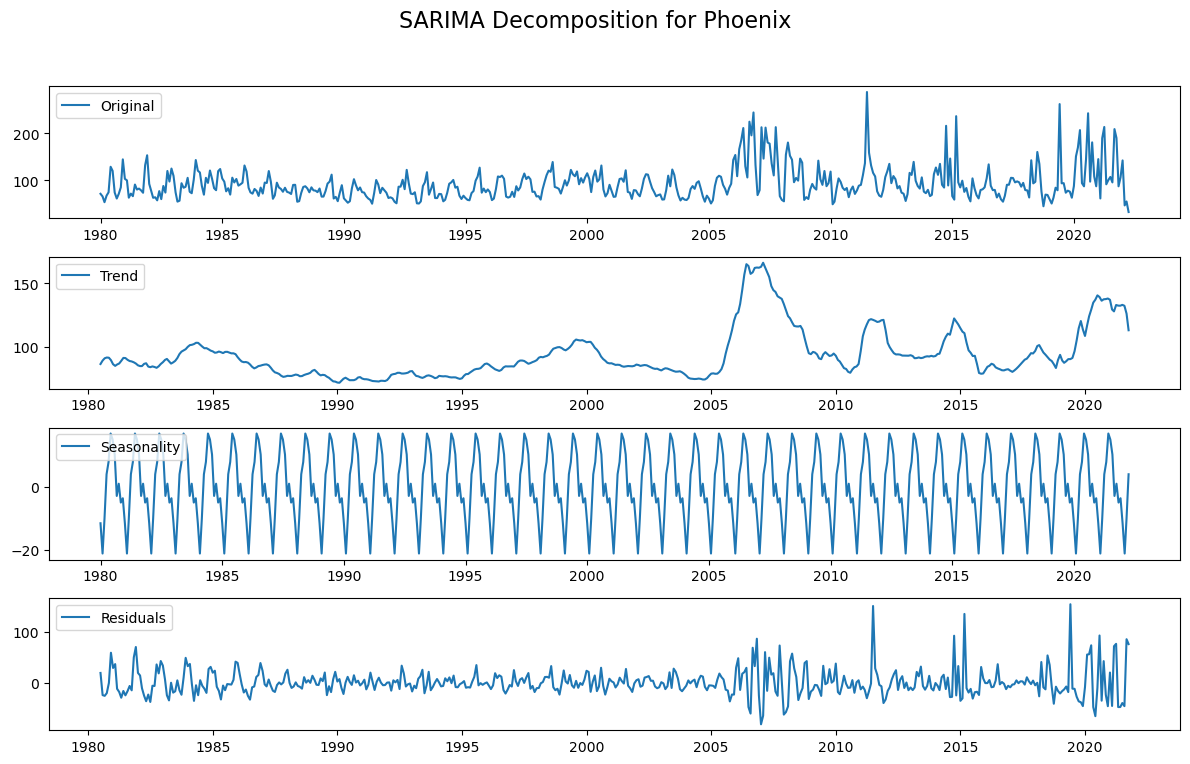

/Users/rileychisholm/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/rileychisholm/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.53337D+00    |proj g|=  5.31608D-02

At iterate    5    f=  4.49086D+00    |proj g|=  2.78799D-02

At iterate   10    f=  4.47338D+00    |proj g|=  6.90171D-02

At iterate   15    f=  4.44752D+00    |proj g|=  8.12550D-02

At iterate   20    f=  4.44072D+00    |proj g|=  1.27981D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     23     27      1     0     0   5.115D-06   4.441D+00
  F =   4.4407110848318361     

CONVERG

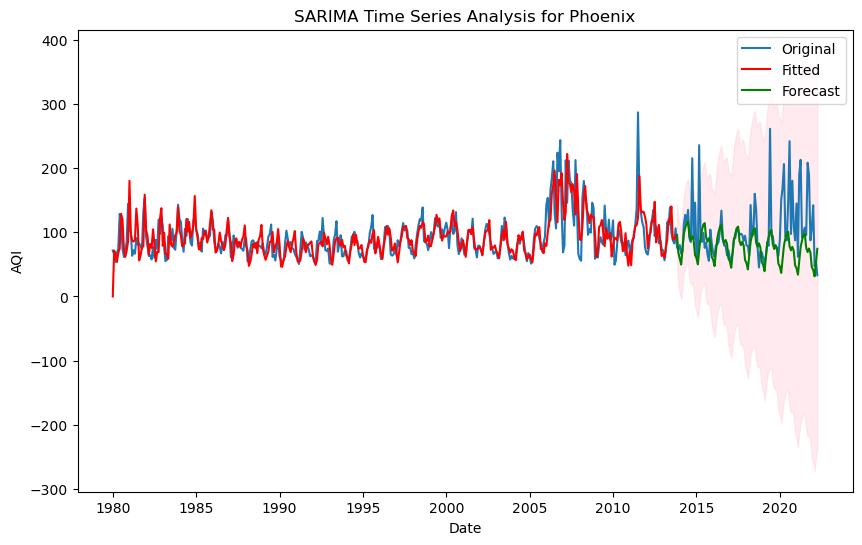

SARIMA Model Summary for Phoenix


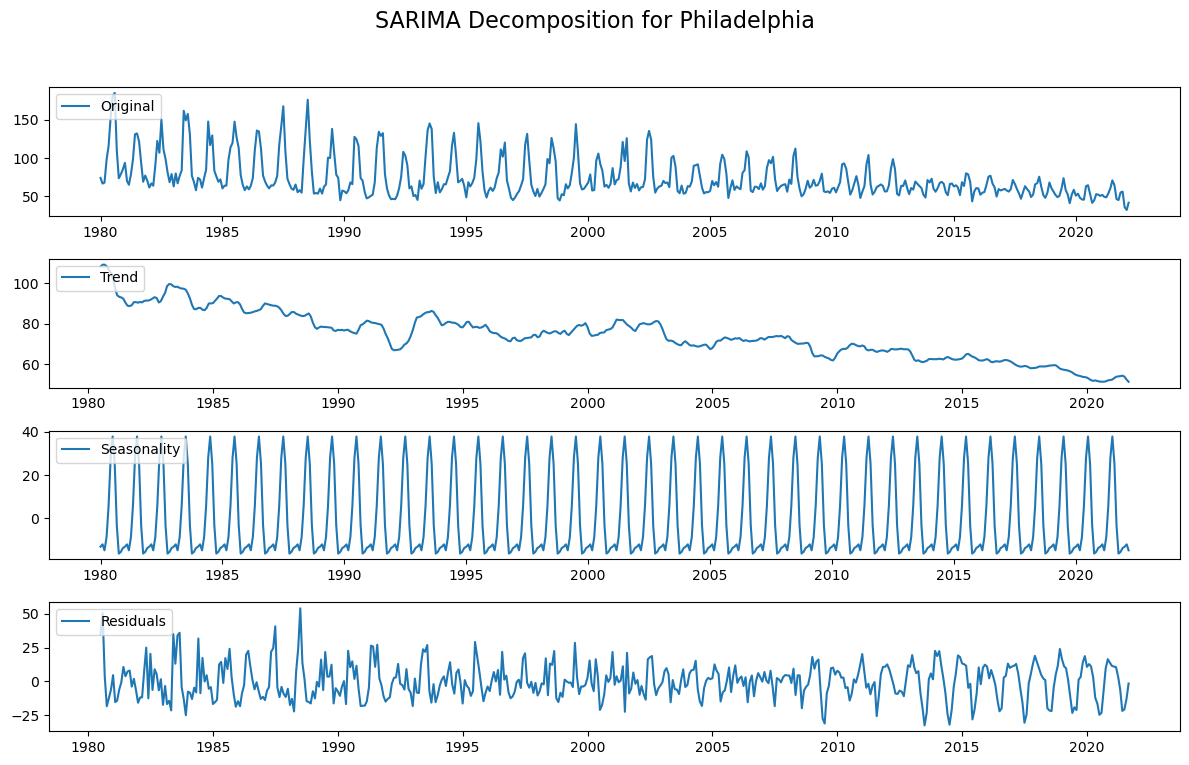

/Users/rileychisholm/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/rileychisholm/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.90785D+00    |proj g|=  9.10126D-02

At iterate    5    f=  3.86873D+00    |proj g|=  2.27170D-02

At iterate   10    f=  3.82401D+00    |proj g|=  2.11024D-02

At iterate   15    f=  3.82251D+00    |proj g|=  7.56287D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     17     23      1     0     0   9.654D-06   3.823D+00
  F =   3.8225064798015467     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


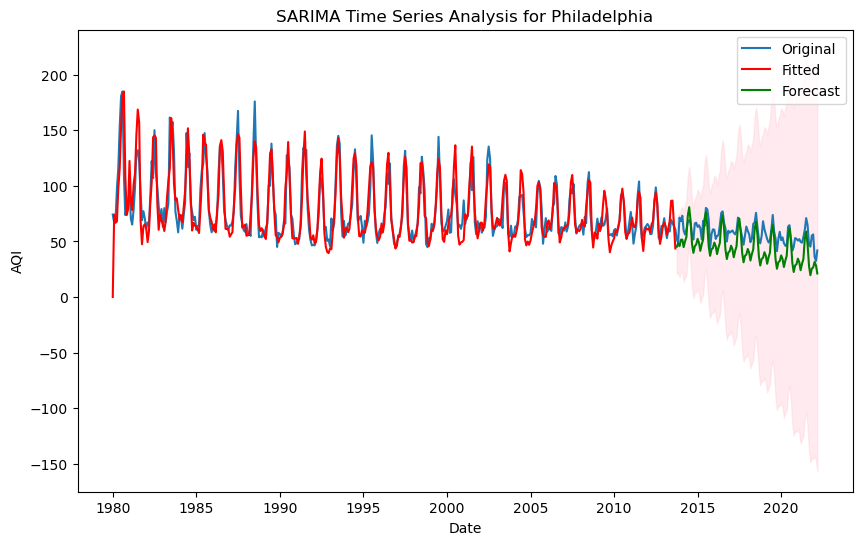

SARIMA Model Summary for Philadelphia


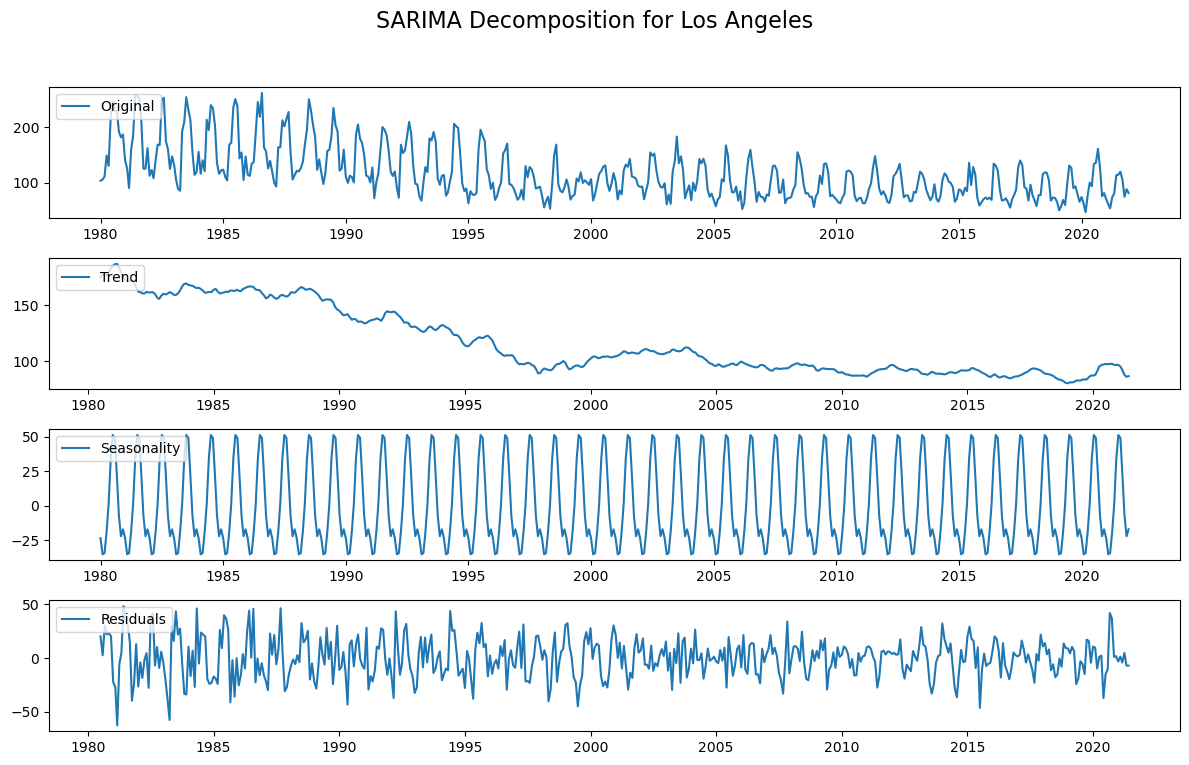

/Users/rileychisholm/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/rileychisholm/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.37120D+00    |proj g|=  6.72077D-02

At iterate    5    f=  4.33785D+00    |proj g|=  1.21475D-02

At iterate   10    f=  4.32571D+00    |proj g|=  2.42255D-02

At iterate   15    f=  4.30810D+00    |proj g|=  3.59972D-02

At iterate   20    f=  4.30698D+00    |proj g|=  1.64697D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     20     24      1     0     0   1.647D-05   4.307D+00
  F =   4.3069815592135621     

CONVERG

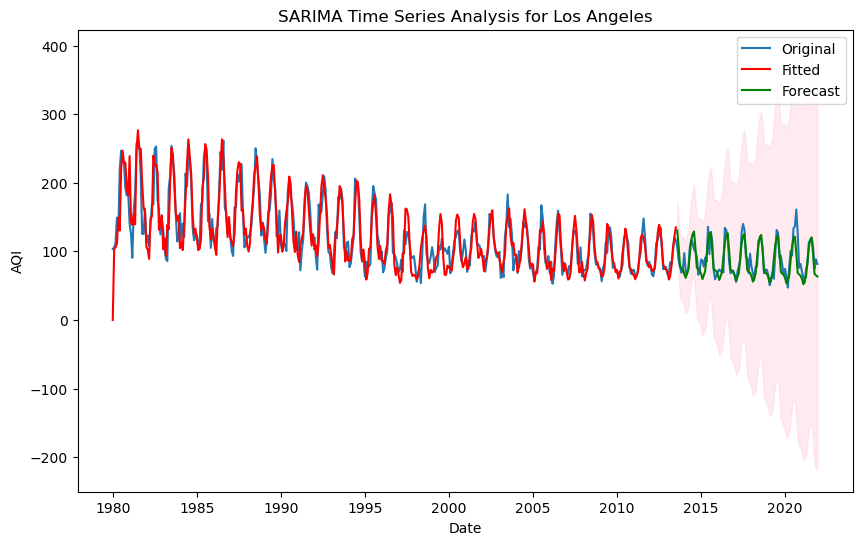

SARIMA Model Summary for Los Angeles


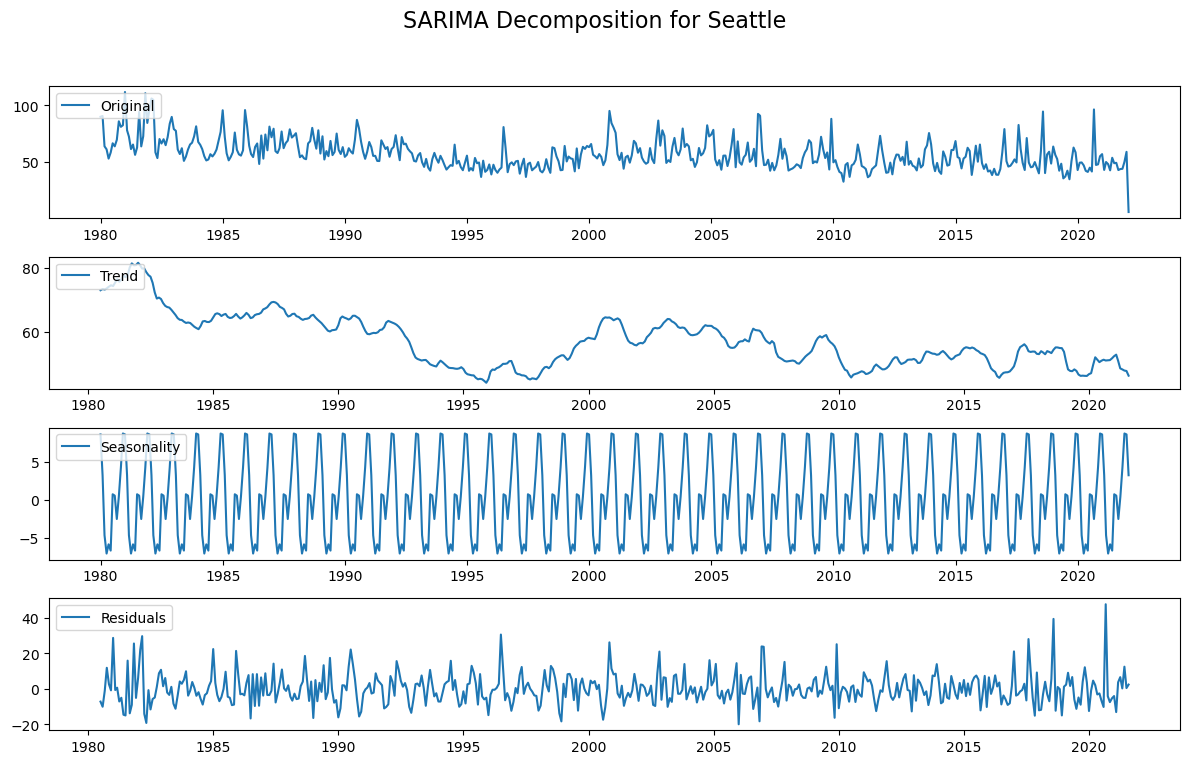

/Users/rileychisholm/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/rileychisholm/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.64188D+00    |proj g|=  4.55929D-02

At iterate    5    f=  3.60568D+00    |proj g|=  2.55214D-02

At iterate   10    f=  3.59176D+00    |proj g|=  6.50469D-03

At iterate   15    f=  3.59155D+00    |proj g|=  1.30129D-02

At iterate   20    f=  3.58773D+00    |proj g|=  4.48555D-02

At iterate   25    f=  3.58453D+00    |proj g|=  2.95297D-03

At iterate   30    f=  3.58452D+00    |proj g|=  1.17114D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

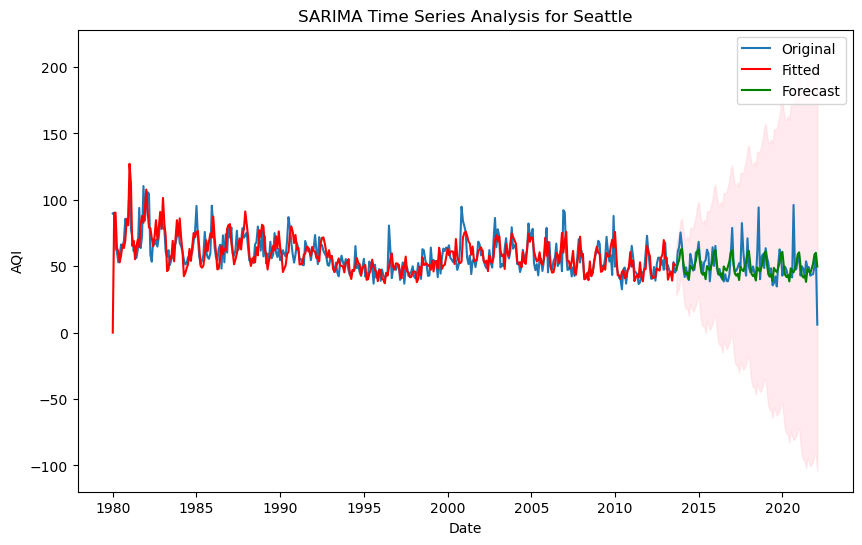

SARIMA Model Summary for Seattle


In [19]:
# Perform SARIMA analysis for each city
for city in cities:
    sarima_city(city)

### Conclusion and Interpretation
In this air quality analysis, we explored the trends in AQI across several major U.S. cities. Overall, the air quality analysis across these cities highlights the complexity of managing urban environments. While population growth is a factor in air quality, it is not the sole determinant. Cities that have implemented robust environmental regulations, invested in cleaner technologies, or benefit from favorable natural conditions tend to have better air quality outcomes. As urban populations continue to grow, understanding and addressing these diverse factors will be essential for ensuring healthy living environments.
